In [0]:
#This code will work with tf 2.x
import cv2
import re
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
#Check the tf version
tf.__version__

'2.2.0'

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [4]:
#In tf2, we will use saved model rather than frozen_inference_graph.pb
model = tf.saved_model.load('/gdrive/My Drive/Colab Notebooks/Capstone/pascal_voc_ssd_model-376/saved_model')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
model = model.signatures['serving_default']

In [6]:
#Check model's input
model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

In [7]:
#Check model's output tensors
model.outputs

[<tf.Tensor 'detection_boxes:0' shape=(None, 100, 4) dtype=float32>,
 <tf.Tensor 'detection_classes:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'detection_multiclass_scores:0' shape=(None, 100, 21) dtype=float32>,
 <tf.Tensor 'detection_scores:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'num_detections:0' shape=(None,) dtype=float32>,
 <tf.Tensor 'raw_detection_boxes:0' shape=(None, None, 4) dtype=float32>,
 <tf.Tensor 'raw_detection_scores:0' shape=(None, None, 21) dtype=float32>]

In [8]:
model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_multiclass_scores': TensorShape([None, 100, 21]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None]),
 'raw_detection_boxes': TensorShape([None, None, 4]),
 'raw_detection_scores': TensorShape([None, None, 21])}

In [0]:
all_classes = {1: 'adhar',
 2: 'alteranatephoneno',
 3: 'alternatemobileno',
 4: 'alternatephoneno',
 5: 'area',
 6: 'city',
 7: 'dob',
 8: 'email',
 9: 'flat',
 10: 'landmark',
 11: 'mobileno',
 12: 'name',
 13: 'pan',
 14: 'phoneno',
 15: 'pin',
 16: 'policyfrom',
 17: 'policyno',
 18: 'policyto',
 19: 'road',
 20: 'state'}

In [10]:
len(all_classes)

20

In [11]:
RESIZE = 4
%cd /content
!mkdir DataImages
!cp -r '/gdrive/.shortcut-targets-by-id/1ff10ymfgpaqHIVjbSF1dtXpL4a3Fbx1J/Set1/' DataImages
%cd 'DataImages/Set1'


/content
/content/DataImages/Set1


In [12]:
for infile in os.listdir("./"):
    #print("file : " + infile)
    words = infile.split(".")
    if (words[1] == "tif" or words[1] == "tiff") :
       im = Image.open(infile)
       out = im.convert("RGB")
       #print(out.size)
       out = out.resize((out.width // RESIZE, out.height //RESIZE))
       #print(out.size)
       outfile = words[0] + ".png"
       #print("new filename : " + outfile)
       out.save(outfile, "png")

!ls *.png |wc

     89      89    2393


In [0]:
!rm *.tif*

In [14]:
files = [f for f in os.listdir('.') if re.match(r'[0-9]+.*\.png', f)]
size = len(files)
print(size)

89


In [0]:
#Function to get predictions from a Detection model
def detector_prediction(image_file, confidence_threshold=0.5):

    """
    image_file: File path of the image for which prediction needs to be done
    confidence_threshold: Minimum confidence/probability for prediction to be considered
    """
    #Load image
    img = tf.keras.preprocessing.image.load_img(image_file)
    
    #Convert to numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')
    #Make it a batch of one example
    img_array = tf.expand_dims(img_array, axis=0)

    #Prediction
    output = model(img_array) #get list of tensors discussed above as output
    detection_scores = output['detection_scores'].numpy()[0] #get detection scores
    detection_classes = output['detection_classes'].numpy()[0]
    detection_boxes = output['detection_boxes'].numpy()[0]

    #Select predictions for which probability is higher than confidence_threshold
    selected_predictions = detection_scores >= confidence_threshold

    selected_prediction_scores = detection_scores[selected_predictions]
    selected_prediction_classes = detection_classes[selected_predictions]
    selected_prediction_boxes = detection_boxes[selected_predictions]

    #De-normalize box co-ordinates (multiply x-coordinates by image width and y-coords by image height)
    img_w, img_h = img.size

    for i in range(selected_prediction_boxes.shape[0]):
        
        selected_prediction_boxes[i,0] *= img_h #ymin * img_w
        selected_prediction_boxes[i,1] *= img_w #xmin * img_h
        selected_prediction_boxes[i,2] *= img_h #ymax * img_w
        selected_prediction_boxes[i,3] *= img_w #xmax * img_h

    #Make all co-ordinates as integer
    selected_prediction_boxes= selected_prediction_boxes.astype(int)

    #Convert class indexes to actual class labels
    predicted_classes = []
    for i in range(selected_prediction_classes.shape[0]):
        predicted_classes.append(all_classes[int(selected_prediction_classes[i])])

    #Number of predictions
    selected_num_predictions = selected_prediction_boxes.shape[0]

    return {'Total Predictions': selected_num_predictions,
            'Scores': selected_prediction_scores, 
            'Classes': predicted_classes, 
            'Box coordinates': selected_prediction_boxes}

(1169, 828, 3)
['pin', 'pan', 'pin', 'pin', 'policyfrom', 'adhar', 'policyno']


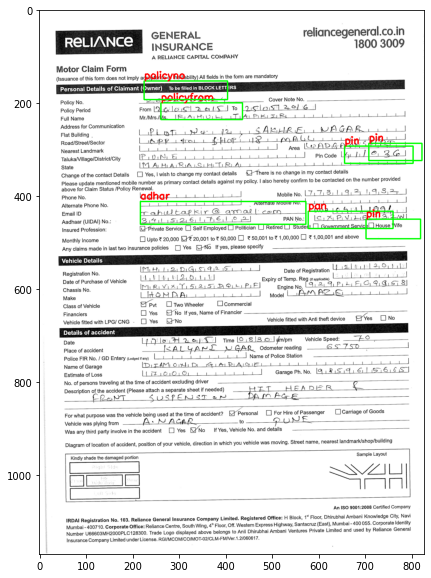

In [37]:
#Pickup a random image number
img_num = np.random.randint(size)
#Read the image
img_file = files[img_num]

img = cv2.imread(img_file)
#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)

#Model predictions for image1.jpg
pred = detector_prediction(img_file, confidence_threshold=0.16)
#print(pred)

preds = pred.get("Total Predictions")
#print(preds)

box_cooredinates = pred.get("Box coordinates")
#print(box_cooredinates)

classes = pred.get("Classes")
print(classes)

for ii in range(0, preds):
  box_coordinate = box_cooredinates[ii]
  #print(box_coordinate)

  #xmin, ymin, xmax, ymax = box_coordinate.flatten()
  ymin, xmin, ymax, xmax = box_coordinate.flatten()
  #print(xmin, ymin, xmax, ymax)

  #Add bounding box
  cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (0,255,0), 2)

  #Add text
  cv2.putText(img,classes[ii],(xmin, ymin-5),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

#Draw image using matplotlib
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()